# ESN for Chaotic Dynamics

### Authors: Elise Özalp (elise.ozalp@imperial.ac.uk), Luca Magri (luca.magri@imperial.ac.uk)


This notebook demonstrates the application of echo state networks (ESN) networks in learning chaotic dynamics of the Lorenz-63 system. Chaotic systems like Lorenz-63 exhibit complex behavior, making them challenging for modeling. See details in the `LSTM_Tutorial_Lorenz63.ipynb`

The Lorenz-63 system is a set of ordinary differential equations that describe a simplified atmospheric convection model. It is a classic example of a chaotic system, characterized by sensitive dependence on initial conditions.

Echo State Networks are a type of recurrent neural network (RNN), based on reservoir computing. We explore how ESNs can be applied to learn and predict the chaotic behavior inherent in systems like Lorenz-63.

Feel free to adapt and expand upon this structure to suit the specific details and findings of your analysis. 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from dynamicalsystems.equations import solve_rk4, lorenz63
from esn.utils import errors, scalers
from esn.validation import validate, set_ESN
from esn.esn import ESN
import scipy.stats as stats

# Generate the data:
Solve the Lorenz 63 system using RK4. The parameters and inital condition are selected to ensure the system is chaotic. 

In [8]:
dim = 3
# Parameters to ensure the system is chaotic
params = [2.667, 28, 10]  # beta, rho, sigma
u0 = np.array([0.0, 1.0, 1.0])  # initial condition

dt = 0.01 # time step
t_lyap = 0.9**(-1)  # Lyapunov time

N_lyap = int(t_lyap/dt)
N_trans = 0  # initial transient to discard
N_total = 1000*N_lyap + N_trans
time_array, U_rk4, derU = solve_rk4(lorenz63, N_total, dt, u0=u0, params=params)
upsampling=1
time_array = time_array[N_trans::upsampling]
U_rk4 = U_rk4[N_trans::upsampling, :dim]  # remove the initial transient

Prepare the training, validation and test data. Allow for a washout phase in the reservoir. 

In [3]:
# set sizes
washout_size = 100
train_size = 10000
val_size = 5000
test_washout_size = 100

# Extract the shape of the original data
total_samples, num_features = U_rk4.shape

# Split the data into different datasets
U_washout = U_rk4[:washout_size, :]
U_train_input = U_rk4[washout_size:washout_size + train_size, :]
U_train_label = U_rk4[washout_size + 1: washout_size + train_size + 1, :]
U_val_input = U_rk4[washout_size + train_size: washout_size + train_size + val_size, :]
U_val_label = U_rk4[washout_size + train_size + 1: washout_size + train_size + val_size + 1, :]
U_test_washout = U_rk4[washout_size + train_size + val_size:washout_size + train_size + val_size + test_washout_size, :]
U_test = U_rk4[washout_size + train_size + val_size + test_washout_size:, :]

# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape}")
print(f"U_val shape: {U_val_input.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: (10000, 3)
U_val shape: (5000, 3)
U_test shape: (95801, 3)


# Training and Validation of ESNs

In [4]:
# specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
param_names = ['spectral_radius', 'input_scaling', 'tikhonov']

# range for hyperparameters 
spec_in = 0.1
spec_end = 1.0
in_scal_in = 0.1
in_scal_end = 10.0
tikh_in = 1e-9
tikh_out= 1e-3
grid_range = [[spec_in, spec_end], [in_scal_in, in_scal_end], [tikh_in, tikh_out]]


# how to scale the search for each hyperparameter in the given range, uniform or in log10
param_scales = ['uniform', 'log10', 'log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])

N_washout = 40 # number of washout steps
N_val = 50  # number of validation steps

# fixed properties of the ESN
ESN_dict = {'reservoir_size': 100,
            'dimension': dim,
            'reservoir_connectivity': 3, 
            'input_bias':np.array([1.0]),
            'output_bias':np.array([1.0]),
            'reservoir_weights_mode':"erdos_renyi1",
            # 'r2_mode': True,
            'input_weights_mode': 'sparse_grouped'
            }

min_dict = validate(
    grid_range=grid_range, 
    param_names=param_names, 
    param_scales=param_scales, 
    n_calls=10, # number of total trials  
    n_initial_points=5, # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict, 
    U_washout_train=U_washout,
    n_realisations=3, # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label, 
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=2, # number of folds, i.e., validation time series that start from random time instances 
    N_washout_steps=N_washout, 
    N_val_steps=N_val, 
    random_seed=20, # random seed for the bayesian optimization
    error_measure=errors.rmse) # error measure to optimize over

Input to run_gp:([Real(low=0.1, high=1.0, prior='uniform', transform='identity'), Real(low=-1.0, high=1.0, prior='uniform', transform='identity'), Integer(low=-9.0, high=-3.0, prior='uniform', transform='identity')], 10, 5, 20)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6335601564025166
input_scaling 4.881255012149711
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  9.225931282692246
Fold: 1 , fold error:  13.57266080498976
Val regime error: 11.399296043841002
Realisation error: 11.399296043841002


Realisation: 1
spectral_radius 0.6335601564025166
input_scaling 4.881255012149711
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  8.234881589827099
Fold: 1 , fold error:  9.37908177134637
Val regime error: 8.806981680586734
Realisation error: 8.806981680586734


Realisation: 2
spectral_radius 0.6335601564025166
input_scaling 4.881255012149711
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  5.2064136388892015
Fold: 1 , fold

# Train the ESN with the best hyperparameter and predict on the test set

In [5]:
my_ESN = ESN(reservoir_size=ESN_dict["reservoir_size"],
             dimension=dim,
             reservoir_connectivity=ESN_dict["reservoir_connectivity"],
             spectral_radius=min_dict['spectral_radius'][0],
             input_scaling=min_dict['input_scaling'][0],
             tikhonov=min_dict['tikhonov'][0],
             input_weights_mode=ESN_dict["input_weights_mode"],
             input_seeds=[0, 1, 2],
             reservoir_seeds=[3, 4])

my_ESN.train(U_washout, U_train_input, U_train_label)
reservoir, prediction = my_ESN.closed_loop_with_washout(U_test_washout, 10000)

Input normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


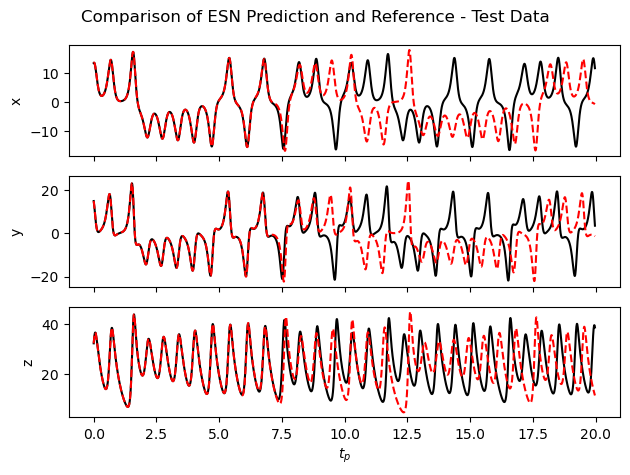

In [6]:
N_plot = 20 * N_lyap
# Define time steps
time_steps = np.arange(0, N_plot * dt, dt) / t_lyap

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, sharex=True)

for i in range(dim):
# Plot prediction and U_test for the third feature
    axes[i].plot(time_steps[:N_plot], U_test[:N_plot, i], color='black', label='Reference')
    axes[i].plot(time_steps[:N_plot], prediction[:N_plot, i], color='red', linestyle='dashed', label='ESN Prediction')

axes[0].set_ylabel("x")
axes[1].set_ylabel("y")
axes[2].set_ylabel("z")
axes[2].set_xlabel("$t_p$")

fig.suptitle("Comparison of ESN Prediction and Reference - Test Data")
plt.tight_layout()
# Show the plot
plt.show()

In [18]:
U_test.shape

(95801, 3)

In [23]:

def stats_lorenz63(prediction_length, U_test_washout):
    reservoir, prediction = my_ESN.closed_loop_with_washout(U_test_washout, prediction_length)

    norm = np.max(U_rk4, axis=0)

    n_bins = 100
    x = np.linspace(-norm,norm,n_bins)

    fig, axs = plt.subplots(1,3, sharey=True, figsize=(8,2.5))

    fig.suptitle('Probability Density Function (PDF)')


    for i in range(dim):
        signal = U_test[:prediction_length,i]
        signal_p  = prediction[:prediction_length,i] #predicted closed loop
        kde = stats.gaussian_kde(signal)
        kde_p = stats.gaussian_kde(signal_p)
            
        axs[i].plot(x[:, i],kde(x[:, i]),color='black', label='Reference')
        axs[i].plot(x[:, i],kde_p(x[:, i]),color='blue', linestyle='dashed', label='ESN Prediction')

    axs[0].set_xlabel('$x$')
    axs[1].set_xlabel('$y$')
    axs[2].set_xlabel('$z$')
    plt.legend()    
    
    return(prediction)


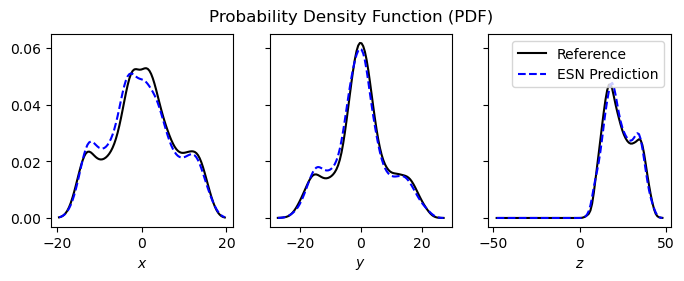

In [26]:
esn_prediction =stats_lorenz63(100*N_lyap, U_test_washout)

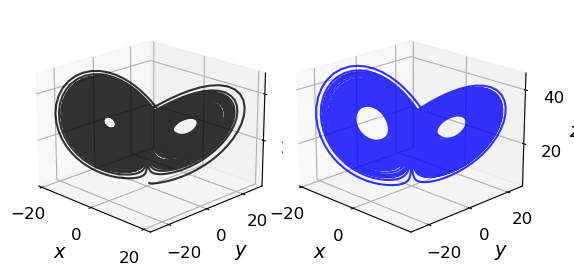

In [28]:
fs=14
fig = plt.figure(figsize=(8, 3))

# First subplot for U_rk4
ax1 = fig.add_subplot(131, projection='3d')

N_plot=20000
n = len(U_rk4[:N_plot])

ax1.plot(U_rk4[:n, 0], U_rk4[:n, 1], U_rk4[:n, 2], color='k', alpha=0.8)
ax1.view_init(elev=20, azim=-45)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel(r'$x$', fontsize=fs)
ax1.set_ylabel(r'$y$', fontsize=fs)
ax1.set_zlabel(r'$z$', fontsize=fs, labelpad=0)
# Second subplot for U_pred_lstm
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(esn_prediction[:n, 0], esn_prediction[:n, 1], esn_prediction[:n, 2], color='b', alpha=0.8)
ax2.view_init(elev=20, azim=-45)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel(r'$x$', fontsize=fs)
ax2.set_ylabel(r'$y$', fontsize=fs)
ax2.set_zlabel(r'$z$', fontsize=fs, labelpad=0)


# Adjust layout for better spacing
plt.subplots_adjust(left=-0.1, right=0.95, bottom=0.1, top=0.9, wspace=0.2)
plt.tight_layout()